# New Additions!

### First Import Necessary Packages

In [2]:
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity
import numpy as np
import pandas as pd
import pylab as py
from scipy.interpolate import RegularGridInterpolator
import pdb
import matplotlib.pyplot as plt
from astropy.table import vstack
%matplotlib inline
%load_ext autoreload
%autoreload

## 1: BD objects in isochron

In [3]:
# Create isochrone object  
logAge = np.log10(5*10**9.)
filt_list = ['wfc3,ir,f153m'] # Only 1 filter for plotting purposes
my_ifmr = ifmr.IFMR_Raithel18()
my_iso = synthetic.IsochronePhot(8, 0, 10,
                                 evo_model = evolution.MergedBaraffePisaEkstromParsec(),  #our new evolution model for BDs
                                      filters=filt_list)

Isochrone generation took 54.561135 s.
Making photometry for isochrone: log(t) = 8.00  AKs = 0.00  dist = 10
     Starting at:  2024-11-12 17:33:26.509247   Usually takes ~5 minutes
Starting filter: wfc3,ir,f153m   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.070 Msun  T =  2794 K  m_hst_f153m = 9.52
M =   0.676 Msun  T =  4395 K  m_hst_f153m = 4.92
M =   0.786 Msun  T =  4896 K  m_hst_f153m = 4.41
M =   0.856 Msun  T =  5198 K  m_hst_f153m = 4.12
M =   0.956 Msun  T =  5590 K  m_hst_f153m = 3.74
M =   1.022 Msun  T =  5808 K  m_hst_f153m = 3.50
M =   1.079 Msun  T =  5992 K  m_hst_f153m = 3.30
M =   1.518 Msun  T =  7482 K  m_hst_f153m = 2.22
M =   4.439 Msun  T = 13246 K  m_hst_f153m = -1.04
M =   4.509 Msun  T = 14299 K  m_hst_f153m = -1.00
M =   5.078 Msun  T =  6015 K  m_hst_f153m = -4.23
      Time taken: 14.44 seconds


In [48]:
bd_idx = np.where(my_iso.points['mass'] < 0.08)
print(my_iso.points[bd_idx])

          L                   Teff        ... phase    m_hst_f153m   
          W                    K          ...                        
---------------------- ------------------ ... ----- -----------------
5.2116102444796556e+23  2793.830151362531 ...     1 9.517653682370574
 5.890768137510784e+23 2838.5725586841204 ...     1  9.39108220785009


In [5]:
# Create sample BD case
# Identify a brown dwarf with mass < 0.08 M_sun
bd_idx = np.where(my_iso.points['mass'] < 0.08)[0]
if len(bd_idx) > 0:
    f153m = np.round(my_iso.points[bd_idx[0]]['m_hst_f153m'], decimals=3)
    mass = my_iso.points[bd_idx[0]]['mass']
    print('Brown dwarf (mass < 0.08 M_sun): F153M = {0} mag'.format(f153m))
else:
    print('No brown dwarf with mass < 0.08 M_sun found.')

Brown dwarf (mass < 0.08 M_sun): F153M = 9.518 mag


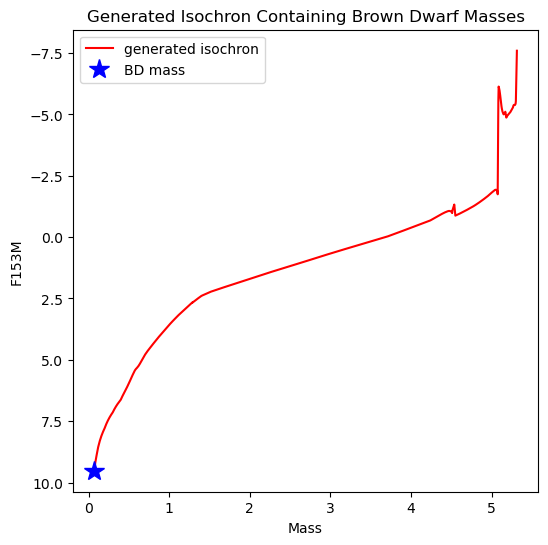

In [42]:
# Make a mass-magnitude diagram from the isochrone and plot a brown dwarf
py.figure(1, figsize=(6,6))
py.clf()
py.plot(my_iso.points['mass'], my_iso.points['m_hst_f153m'], 'r-', label='generated isochron')
py.plot(my_iso.points['mass'][bd_idx[0]], my_iso.points['m_hst_f153m'][bd_idx[0]], 'b*', ms=15, label='BD mass')
py.title('Generated Isochron Containing Brown Dwarf Masses')
py.xlabel('Mass')
py.ylabel('F153M')
py.gca().invert_yaxis()
py.legend()
py.show()

## 2. BD Objects in Cluster (Primary and Companions)

In [7]:
# Create IMF objects                                                                                                                                                     
imf_multi = multiplicity.MultiplicityUnresolved()
kc_imf = imf.CombinedWeidnerKroupaKirkpatrick_2024(multiplicity=imf_multi)

In [8]:
# Make cluster
cluster_mass = 10**6
kc_cluster = synthetic.ResolvedCluster(my_iso, kc_imf, cluster_mass, ifmr=my_ifmr)

# Get outputs
kc_out = kc_cluster.star_systems
kc_comp = kc_cluster.companions

/opt/mambaforge3/envs/astro/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/mambaforge3/envs/astro/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Found 8520 companions out of stellar mass range


/opt/mambaforge3/envs/astro/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/mambaforge3/envs/astro/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


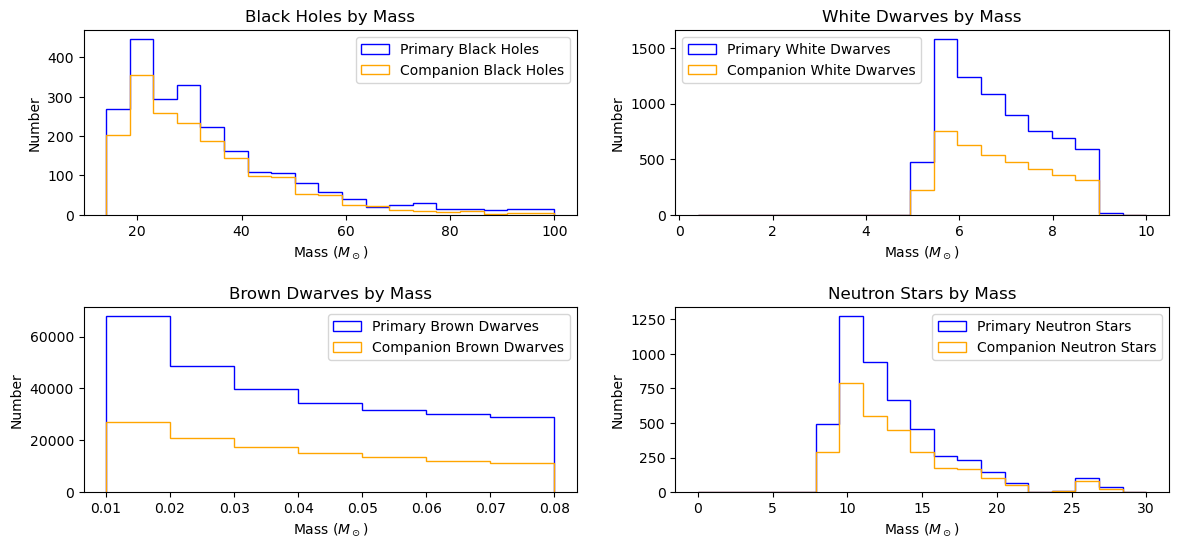

In [66]:
# Locate BHs, NSs, WDs, and BDs
p2_bh = np.where(kc_out['phase'] == 103)[0]
c_bh = np.where(kc_comp['phase'] == 103)[0]
p2_ns = np.where(kc_out['phase'] == 102)[0]
c_ns = np.where(kc_comp['phase'] == 102)[0]
p2_wd = np.where(kc_out['phase'] == 101)[0]
c_wd = np.where(kc_comp['phase'] == 101)[0]
p2_bd = np.where(kc_out['phase'] == 90)[0]
c_bd = np.where(kc_comp['phase'] == 90)[0]

# Define bins for histograms
bh_bins = np.linspace(14, 100, 20)
wd_bins = np.linspace(0.4, 10, 20)
bd_bins = np.linspace(0.01, 0.08, 8)
ns_bins = np.linspace(0, 30, 20)

# Create subplots
plt.figure(figsize=(14,6))

# Plot BHs
plt.subplot(2, 2, 1)
plt.hist(kc_out[p2_bh]['mass'], histtype='step', bins=bh_bins, label='Primary Black Holes', color='blue')
plt.hist(kc_comp[c_bh]['mass'], histtype='step', bins=bh_bins, label='Companion Black Holes', color='orange')
plt.title("Black Holes by Mass")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

# Plot WDs
plt.subplot(2, 2, 2)
plt.hist(kc_out[p2_wd]['mass'], histtype='step', bins=wd_bins, label='Primary White Dwarves', color='blue')
plt.hist(kc_comp[c_wd]['mass'], histtype='step', bins=wd_bins, label='Companion White Dwarves', color='orange')
plt.title("White Dwarves by Mass")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

# Plot BDs
plt.subplot(2, 2, 3)
plt.hist(kc_out[p2_bd]['mass'], histtype='step', bins=bd_bins, label='Primary Brown Dwarves', color='blue')
plt.hist(kc_comp[c_bd]['mass'], histtype='step', bins=bd_bins, label='Companion Brown Dwarves', color='orange')
plt.title("Brown Dwarves by Mass")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

# Plot NSs
plt.subplot(2, 2, 4)
plt.hist(kc_out[p2_ns]['mass'], histtype='step', bins=ns_bins, label='Primary Neutron Stars', color='blue')
plt.hist(kc_comp[c_ns]['mass'], histtype='step', bins=ns_bins, label='Companion Neutron Stars', color='orange')
plt.title("Neutron Stars by Mass")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

# Adjust space between subplots
plt.subplots_adjust(hspace=0.5)

# Show the plots
plt.show()


In [10]:
print(np.min(kc_out[p2_bd]['Teff']))
print(np.min(kc_comp[c_bd]['Teff']))
print(np.max(kc_out[p2_bd]['Teff']))
print(np.max(kc_comp[c_bd]['Teff']))

287.80180827780606
287.80439454686973
2321.1956912624596
2321.1948222119263


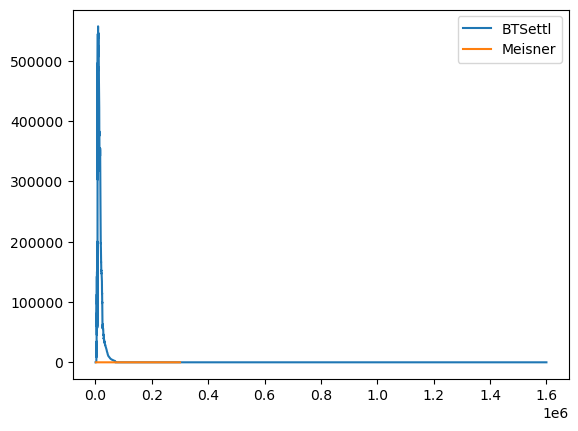

In [32]:
from astropy.io import fits
from astropy.table import Table

# plotting 1200K star from Meisner vs. BTSettl
bt_file = '/System/Volumes/Data/mnt/g/lu/models/cdbs/grid/BTSettl_rebin/btm05/lte033-3.0-0.5a+0.2.BT-Settl.spec.fits'
m_file = '/System/Volumes/Data/mnt/g/lu/models/cdbs/grid/Meisner2023/mp00/spec_jwst_t1200_g4.5_p0_kg_g1.25.fits'
p_file = '/System/Volumes/Data/mnt/g/lu/models/cdbs/grid/Phillips2020/spec_T1200_lg4.5_CEQ.fits'

b_hdu_list = fits.open(bt_file)
m_hdu_list = fits.open(m_file)
p_hdu_list = fits.open(p_file)

b_data = Table(b_hdu_list[1].data)
m_data = Table(m_hdu_list[1].data)
p_data = Table(p_hdu_list[1].data)

b_w = np.array(b_data['Wavelength'])
b_f = np.array(b_data['Flux'])
m_w = np.array(m_data['Wavelength'])
m_f = np.array(m_data['Flux'])
p_w = np.array(p_data['Flux'])
p_f = np.array(p_data['Wavelength'])

plt.figure()
plt.plot(b_w, b_f, label = 'BTSettl')
plt.plot(m_w, m_f, label = 'Meisner')
plt.legend()
plt.show()

In [33]:
print(np.min(b_w))
print(np.min(b_f))
print(np.min(m_w))
print(np.min(m_f))
print('\n')
print(np.max(b_w))
print(np.max(b_f))
print(np.max(m_w))
print(np.max(m_f))

90.9000015258789
0.0
2000.3333534194462
1.524743e-33


1600000.0
557203.6
299949.9969872583
1.1996874e-15


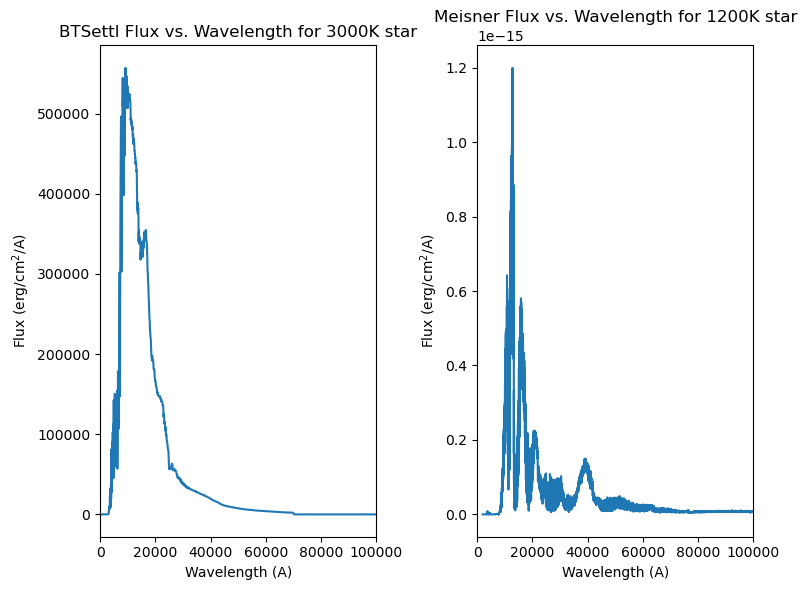

In [34]:
plt.figure(figsize = (8,6))

plt.subplot(1, 2, 1)
plt.plot(b_w, b_f)
plt.title('BTSettl Flux vs. Wavelength for 3000K star')
plt.xlabel('Wavelength (A)')
plt.ylabel('Flux (erg/cm$^2$/A)')
plt.xlim(0, 1e5)

plt.subplot(1, 2, 2)
plt.plot(m_w, m_f)
plt.title('Meisner Flux vs. Wavelength for 1200K star')
plt.xlabel('Wavelength (A)')
plt.ylabel('Flux (erg/cm$^2$/A)')
plt.xlim(0, 1e5)

plt.tight_layout()

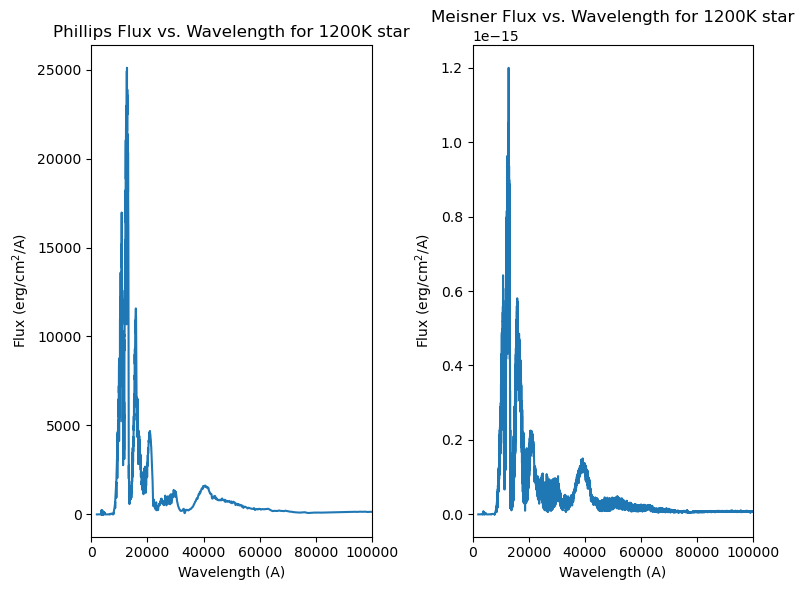

In [39]:
# Where did Phillips peak for 1200K star?
plt.figure(figsize = (8,6))

plt.subplot(1, 2, 1)
plt.plot(p_f, p_w)
plt.title('Phillips Flux vs. Wavelength for 1200K star')
plt.xlabel('Wavelength (A)')
plt.ylabel('Flux (erg/cm$^2$/A)')
plt.xlim(0, 1e5)

plt.subplot(1, 2, 2)
plt.plot(m_w, m_f)
plt.title('Meisner Flux vs. Wavelength for 1200K star')
plt.xlabel('Wavelength (A)')
plt.ylabel('Flux (erg/cm$^2$/A)')
plt.xlim(0, 1e5)

plt.tight_layout()
plt.show()

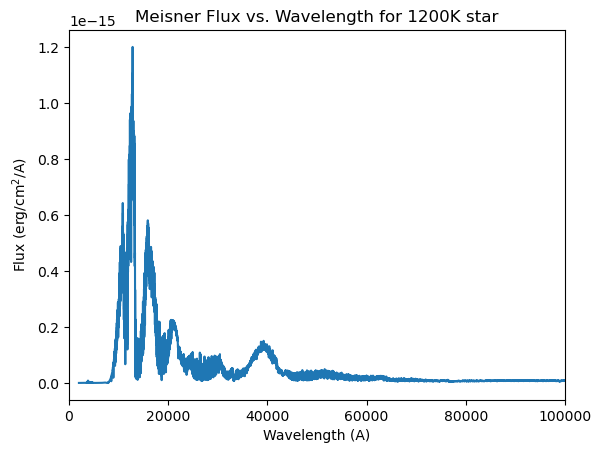

In [36]:
plt.figure()
plt.plot(m_w, m_f)
plt.title('Meisner Flux vs. Wavelength for 1200K star')
plt.xlabel('Wavelength (A)')
plt.ylabel('Flux (erg/cm$^2$/A)')
plt.xlim(0, 1e5)
plt.show()

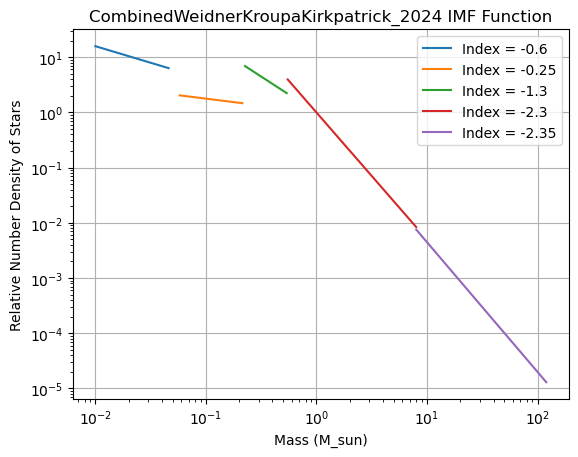

In [23]:
# Plotting new IMF

mass_range = np.linspace(0.01, 120, 10000)

def power_law(masses, index):
    return masses**index

plt.figure()

# Define each mass range and plot with the corresponding index
mass_1 = mass_range[(mass_range >= 0.01) & (mass_range < 0.05)]
plt.plot(mass_1, power_law(mass_1, -0.6), label='Index = -0.6')

mass_2 = mass_range[(mass_range >= 0.05) & (mass_range < 0.22)]
plt.plot(mass_2, power_law(mass_2, -0.25), label='Index = -0.25')

mass_3 = mass_range[(mass_range >= 0.22) & (mass_range < 0.55)]
plt.plot(mass_3, power_law(mass_3, -1.3), label='Index = -1.3')

mass_4 = mass_range[(mass_range >= 0.55) & (mass_range < 8)]
plt.plot(mass_4, power_law(mass_4, -2.3), label='Index = -2.3')

mass_5 = mass_range[(mass_range >= 8) & (mass_range <= 120)]
plt.plot(mass_5, power_law(mass_5, -2.35), label='Index = -2.35')

# Add labels and legend
plt.xlabel('Mass (M_sun)')
plt.ylabel('Relative Number Density of Stars')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.title('CombinedWeidnerKroupaKirkpatrick_2024 IMF Function')
plt.grid()

plt.show()


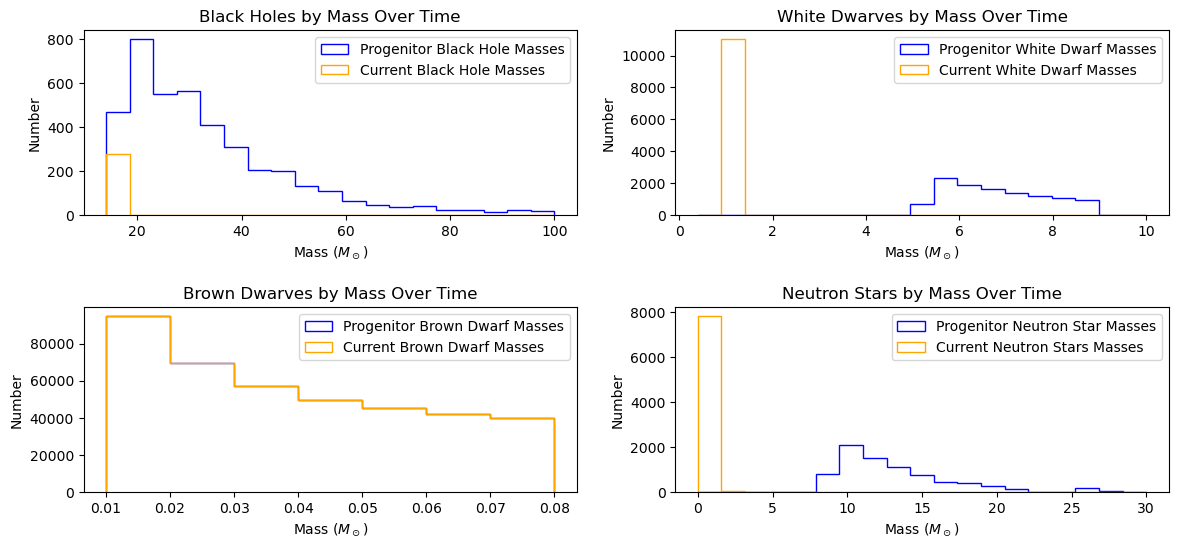

In [67]:
# Locate BHs, NSs, WDs, and BDs
p2_bh = np.where(kc_out['phase'] == 103)[0]
c_bh = np.where(kc_comp['phase'] == 103)[0]
k_bh = vstack([kc_out[p2_bh], kc_comp[c_bh]])
p2_ns = np.where(kc_out['phase'] == 102)[0]
c_ns = np.where(kc_comp['phase'] == 102)[0]
k_ns = vstack([kc_out[p2_ns], kc_comp[c_ns]])
p2_wd = np.where(kc_out['phase'] == 101)[0]
c_wd = np.where(kc_comp['phase'] == 101)[0]
k_wd = vstack([kc_out[p2_wd], kc_comp[c_wd]])
p2_bd = np.where(kc_out['phase'] == 90)[0]
c_bd = np.where(kc_comp['phase'] == 90)[0]
k_bd = vstack([kc_out[p2_bd], kc_comp[c_bd]])

# Create subplots
plt.figure(figsize=(14,6))

# Plot BHs
plt.subplot(2, 2, 1)
plt.hist(k_bh['mass'], histtype='step', bins=bh_bins, label='Progenitor Black Hole Masses', color='blue')
plt.hist(k_bh['mass_current'], histtype='step', bins=bh_bins, label='Current Black Hole Masses', color='orange')
plt.title("Black Holes by Mass Over Time")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

# Plot WDs
plt.subplot(2, 2, 2)
plt.hist(k_wd['mass'], histtype='step', bins=wd_bins, label='Progenitor White Dwarf Masses', color='blue')
plt.hist(k_wd['mass_current'], histtype='step', bins=wd_bins, label='Current White Dwarf Masses', color='orange')
plt.title("White Dwarves by Mass Over Time")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

# Plot BDs
plt.subplot(2, 2, 3)
plt.hist(k_bd['mass'], histtype='step', bins=bd_bins, label='Progenitor Brown Dwarf Masses', color='blue')
plt.hist(k_bd['mass_current'], histtype='step', bins=bd_bins, label='Current Brown Dwarf Masses', color='orange')
plt.title("Brown Dwarves by Mass Over Time")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

# Plot NSs
plt.subplot(2, 2, 4)
plt.hist(k_ns['mass'], histtype='step', bins=ns_bins, label='Progenitor Neutron Star Masses', color='blue')
plt.hist(k_ns['mass_current'], histtype='step', bins=ns_bins, label='Current Neutron Stars Masses', color='orange')
plt.title("Neutron Stars by Mass Over Time")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

# Adjust space between subplots
plt.subplots_adjust(hspace=0.5)

# Show the plots
plt.show()


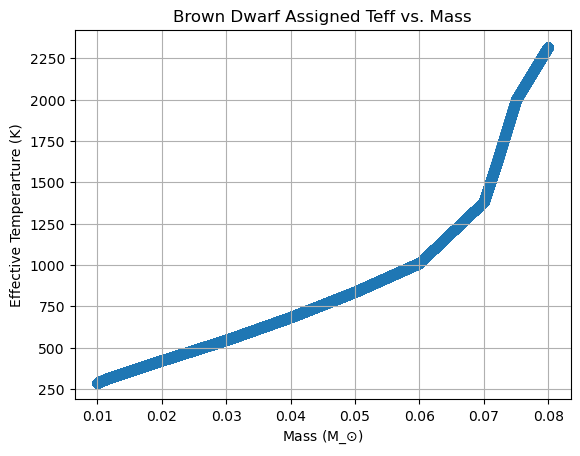

In [46]:
plt.figure()
plt.scatter(kc_out[p2_bd]['mass'], kc_out[p2_bd]['Teff'])
plt.title('Brown Dwarf Assigned Teff vs. Mass')
plt.xlabel('Mass (M_$\odot$)')
plt.ylabel('Effective Temperarture (K)')
plt.grid()
plt.show()

In [65]:
np.min(k_ns['mass_current'])
np.max(k_ns['mass_current'])
len(k_ns['mass_current'])

7870